In [76]:
from matplotlib import pyplot as plt
import numpy as np
import cmath
from scipy import interpolate
import pandas as pd
from ast import literal_eval
import scipy.stats as stat


# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

In [47]:
def getArrayFromFunc(func,inputs):
    output = []
    for input in inputs:
        output.append((func(input)).real)
    return output

circ_constants = (3*10**(-8),0.35,619,50,10,0.0343,4.752*10**(-9),50,1.027*10**(-10),2.542*10**(-7),0,0,0,0)

L0 = circ_consts[0]
Rcoil = circ_consts[1]
R = circ_consts[2]
R1 = circ_consts[3]
r = circ_consts[4]
alpha = circ_consts[5]
beta1 = circ_consts[6]
Z_cable = circ_consts[7]
D = circ_consts[8]
M = circ_consts[9]
delta_C = circ_consts[10]
delta_phi = circ_consts[11]
delta_phase = circ_consts[12]
delta_l = circ_consts[13]

# f = 32000000

g = 0.05
s = 0.04
bigy=(3-s)**0.5

k_range = 5000

scansize = .25
ranger = 0

Deuteron_Deriv = Deuteron_Dat = np.empty(256)

U = 0.1
# Cknob = 0.125
Cknob = 0.016
cable = 2.5
eta = 0.0104
phi = 6.1319
Cstray = 10**(-15)

circ_params = (U,Cknob,cable,eta,phi,Cstray)

In [66]:
pi = np.pi
im_unit = complex(0,1)
sign = 1


def QCurve(signal,U,knob,trim,eta,phi_const,Cstray):

    circ_consts = (3*10**(-8),0.35,619,50,10,0.0343,4.752*10**(-9),50,1.027*10**(-10),2.542*10**(-7),0,0,0,0)

    L0 = circ_consts[0]
    Rcoil = circ_consts[1]
    R = circ_consts[2]
    R1 = circ_consts[3]
    r = circ_consts[4]
    alpha = circ_consts[5]
    beta1 = circ_consts[6]
    Z_cable = circ_consts[7]
    D = circ_consts[8]
    M = circ_consts[9]
    delta_C = circ_consts[10]
    delta_phi = circ_consts[11]
    delta_phase = circ_consts[12]
    delta_l = circ_consts[13]

    # f = 32000000

    g = 0.05
    s = 0.04
    bigy=(3-s)**0.5

    k_range = 5000

    scansize = .25
    ranger = 0
    
    I = U*1000/R #Ideal constant current, mA


#Derived quantities
    f = 32000000
    w_res = 2*pi*f
    w_low = 2 * pi * (213 - scansize) * (1e6)
    w_high = 2 * pi * (213 + scansize) * (1e6)
    delta_w = 2 * pi * 500 * ((1e3)/500)        

    #Functions
    def slope():
        return delta_C / (0.25 * 2 * pi * 1e6)

    def slope_phi():
        return delta_phi / (0.25 * 2 * pi * 1e6)

    def Ctrim(w):
        return slope()*(w - w_res)

    def Cmain():
        return 20*(1e-12)*knob

    def C(w):
        return Cmain() + Ctrim(w)*(1e-12)

    def Cpf():
        return C(w_res)*(1e12)

    #Derived quantities
    S = 2*Z_cable*alpha

    #Functions

    def Z0(w):
        return cmath.sqrt( (S + w*M*im_unit) / (w*D*im_unit))

    def beta(w):
        return beta1*w

    def gamma(w):
        return complex(alpha,beta(w))

    def ZC(w):
        if  w != 0 and C(w) != 0:
            return 1/(im_unit*w*C(w))
        return 1

    #More derived quantities
    vel = 1/beta(1)

    #More functions
    def lam(w):
        return vel/f

    #Even more derived quantities
    l_const = trim*lam(w_res)

    #Even more functions
    def l(w):
        return l_const + delta_l
    
        #Variables for creating splines
    k_ints = range(0,512)
    k = np.array(k_ints,float)
    x = (k*delta_w)+(w_low)

    Icoil = np.loadtxt('current.dat',unpack = True)


    x1 = interpolate.interp1d(x,signal,fill_value=0.0,bounds_error=False)
    x2 = interpolate.interp1d(x,signal,fill_value=0.0,bounds_error=False)

    # ic = interpolate.interp1d(x,Icoil,fill_value="extrapolate",kind="linear",bounds_error=False)
    
    def chi(w):
        return complex(x1(w),-1*x2(w))


    Icoil_TE = 0.11133

    def pt(w):
        # return ic(w)/Icoil_TE
        return float(1)

    def L(w):
        return L0*(1+(sign*4*pi*eta*pt(w)*chi(w)))

    def real_L(w):
        return L(w).real

    def imag_L(w):
        return L(w).imag

    def ZLpure(w):
        return im_unit*w*L(w) + Rcoil

    def Zstray(w):
        if w != 0 and Cstray !=0:
            return 1/(im_unit*w*Cstray)
        return 1

    def ZL(w):
        return ZLpure(w)*Zstray(w)/(ZLpure(w)+Zstray(w))

    def ZT(w):
        return Z0(w)*(ZL(w) + Z0(w)*np.tanh(gamma(w)*l(w)))/(Z0(w) + ZL(w)*np.tanh(gamma(w)*l(w)))


    def Zleg1(w):
        return r + ZC(w) + ZT(w)

    def Ztotal(w):
        return R1 / (1 + (R1 / Zleg1(w)) )

    #Adding parabolic term

    xp1 = w_low
    xp2 = w_res
    xp3 = w_high
    yp1 = 0
    yp2 = delta_phase
    yp3 = 0

    alpha_1 = yp1-yp2
    alpha_2 = yp1-yp3
    beta_1 = (xp1*xp1) - (xp2*xp2)
    beta_2 = (xp1*xp1) - (xp3*xp3)
    gamma_1 = xp1-xp2
    gamma_2 = xp1-xp3
    temp=(beta_1*(gamma_1/gamma_2) - beta_2)
    a= (gamma_2 *(alpha_1/gamma_1) - alpha_2)/temp
    bb = (alpha_2 - a*beta_2)/gamma_2
    c = yp1 - a*xp1*xp1 - bb*xp1

    def parfaze(w):
        return a*w*w + bb*w + c

    def phi_trim(w):
        return slope_phi()*(w-w_res) + parfaze(w)

    def phi(w):
        return phi_trim(w) + phi_const

    def V_out(w):
        return -1*(I*Ztotal(w)*np.exp(im_unit*phi(w)*pi/180))

    
    larger_k = range(0,k_range)
    larger_x = np.array(larger_k, float)
    w_range = w_high - w_low
    larger_range = (delta_w*larger_x)+(w_low-5*w_range)

    # w_res = 2*pi*f
    # w_low = 2 * pi * (213 - scansize) * (1e6)
    # w_high = 2 * pi * (213 + scansize) * (1e6)
    # delta_w = 2 * pi * 500 * ((1e3)/500)
    
    out_y = getArrayFromFunc(V_out,x)
    # if (rangesize == 1):
        # out_y = getArrayFromFunc(V_out,larger_range)
    return out_y
    

In [53]:
def Lineshape(x,P,U,knob,trim,eta,phi_const,Cstray):
    
    def cosal(x,eps):
        return (1-eps*x-s)/bigxsquare(x,eps)
    
    def c(x):
        return ((g**2+(1-x-s)**2)**0.5)**0.5


    def bigxsquare(x,eps):
        return (g**2+(1-eps*x-s)**2)**0.5


    def mult_term(x,eps):
        return float(1)/(2*np.pi*np.sqrt(bigxsquare(x,eps)))


    def cosaltwo(x,eps):
        return ((1+cosal(x,eps))/2)**0.5


    def sinaltwo(x,eps):
        return ((1-cosal(x,eps))/2)**0.5


    def termone(x,eps):
        return np.pi/2+np.arctan((bigy**2-bigxsquare(x,eps))/((2*bigy*(bigxsquare(x,eps))**0.5)*sinaltwo(x,eps)))


    def termtwo(x,eps):
        return np.log((bigy**2+bigxsquare(x,eps)+2*bigy*(bigxsquare(x,eps)**0.5)*cosaltwo(x,eps))/(bigy**2+bigxsquare(x,eps)-2*bigy*(bigxsquare(x,eps)**0.5)*cosaltwo(x,eps)))

    def icurve(x,eps):
        return mult_term(x,eps)*(2*cosaltwo(x,eps)*termone(x,eps)+sinaltwo(x,eps)*termtwo(x,eps))
    
    Iplus = icurve(x,1)
    Iminus = icurve(x,-1)

    r = (np.sqrt(4-3*P**(2))+P)/(2-2*P)

    array = r*Iminus
    array_flipped = np.flip(array)
    element_1 = array_flipped+Iminus
    sum_array = np.sum(array_flipped)*(12/500)
    element_2 = 1/sum_array
    element_3 = P
    signal = element_1*element_2*element_3
    
    lineshape = QCurve(signal,U,knob,trim,eta,phi_const,Cstray)

    return lineshape

    




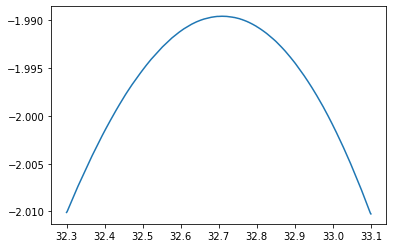

In [99]:
df = pd.read_csv('Deuteron.csv',delimiter=',')

f_values = df['freq_list'].apply(literal_eval)

baseline_values = df['baseline'].apply(literal_eval)

lineshape_values = df['fitsub'].apply(literal_eval)

f = np.array(f_values[1])
V = np.array(baseline_values[1])
plt.plot(f,V)
# V = np.array(lineshape_values[6])



In [86]:
def chi_squared(U,knob,trim,eta,phi_const,Cstray):
    chi_squared = stat.chisquare(QCurve(f,U,knob,trim,eta,phi_const,Cstray),V)
    # for i in range(len(f)):
    #     # Calculate the expected value using the baseline function A
    #     expected = QCurve(f[i],U,knob,trim,eta,phi_const,Cstray)
        
    #     # Calculate the residual
    #     residual = (V[i] - expected) 
    #     # since we don't have the uncertainties you can just consider the squared deviation
    #     # Accumulate the chi-squared value
    #     chi_squared += residual**2   
    return chi_squared[0]


In [107]:
fit = Minuit(chi_squared,U = 0.1, knob= .91,trim= 1.5,eta= 0.0104,phi_const= 6.1319,Cstray= 10**(-15))

fit.limits['U'] = (0.001,20)
fit.limits['knob'] = (.001,1)
fit.limits['trim'] = (0,3)
fit.limits['eta'] = (0.005,.1)
fit.limits['phi_const'] = (.05,7)
fit.limits['Cstray'] = (10**(-20), 10**(-5))

fit.migrad()
# print(np.array(fit.values))
# print(np.array(fit.errors))
fit.hesse()
# print(np.array(fit.values))
# print(np.array(fit.errors))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6.676e+08                 │             Nfcn = 1407              │
│ EDM = 168 (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ U         │19.999999999│0.000000015│            │            │  0.001  │   20    │       │
│ 1 │ knob      │1.00000e-3 │0.00019e-3 │            │            │  0.001  │    1    │       │
│ 2 │ trim      │  1.5019   │  0.0010   │            │            │    0    │    3    │       │
│ 3 │ eta       │   0.06    │   0.07    │            │            │  0.005  │   0.1   │       │
│ 4 │ phi_const │  0.0663   │  0.0024   │            │            │  0.05   │    7    │       │
│ 5 │ Cstray    │   0e-6    │   9e-6    │            │            │  1e-20  │  1e-05  │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────┐
│           │         U      knob      trim       eta phi_const    Cstray │
├───────────┼─────────────────────────────────────────────────────────────┤
│         U │  5.27e-17 -3.58e-24  9.51e-19 -1.17e-17  2.68e-18 -2.63e-22 │
│      knob │ -3.58e-24   1.5e-17  1.31e-13  4.22e-15 -1.16e-12    -3e-17 │
│      trim │  9.51e-19  1.31e-13  9.44e-07  3.12e-08 -5.23e-09 -2.08e-10 │
│       eta │ -1.17e-17  4.22e-15  3.12e-08   0.00394 -3.01e-10 -3.02e-11 │
│ phi_const │  2.68e-18 -1.16e-12 -5.23e-09 -3.01e-10  5.64e-06  2.14e-12 │
│    Cstray │ -2.63e-22    -3e-17 -2.08e-10 -3.02e-11  2.14e-12     2e-13 │
└───────────┴─────────────────────────────────────────────────────────────┘

In [16]:
def chi_squared_lineshape(P,U,knob,trim,eta,phi_const,Cstray):
    chi_squared = stat.chisquare(Lineshape(f[i],P,U,knob,trim,eta,phi_const,Cstray))
    # chi_squared = 0
    # # for i in range(len(f)):
    #     # Calculate the expected value using the baseline function A
    #     expected = Lineshape(f[i],P,U,knob,trim,eta,phi_const,Cstray)
        
    #     # Calculate the residual
    #     residual = (V[i] - expected) 
    #     # since we don't have the uncertainties you can just consider the squared deviation
    #     # Accumulate the chi-squared value
    #     chi_squared += residual**2   
    return chi_squared

In [75]:
fit = Minuit(chi_squared_lineshape,P = df['pol'][6],U = 0.7, knob= .016,trim= 1.5,eta= 0.0104,phi_const= 6.1319,Cstray= 10**(-15))

fit.fixed['P'] = True
fit.limits['U'] = (0.001,1)
fit.limits['knob'] = (.01,1)
fit.limits['trim'] = (0,3)
fit.limits['eta'] = (0,.1)
fit.limits['phi_const'] = (0,2*np.pi)
fit.limits['Cstray'] = (10**(-16), 10**(-14))

fit.migrad()
fit.hesse()

ValueError: x and y arrays must be equal in length along interpolation axis.

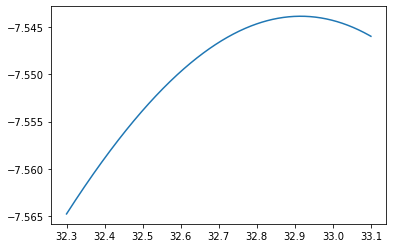

In [74]:
# plt.plot(f,V)
# x = np.linspace(32.3,33.1,512)
# data_x = []
# for i in range(len(f)):
#     data_x.append(QCurve(f[i],U = 0.1, knob= 0.016,trim= 1.5,eta= 0.0104,phi_const= 6.1319,Cstray= 10**(-15)))

y = QCurve(f,U = 0.1, knob= 0.116,trim= 1.5,eta= 0.0104,phi_const= 6.1319,Cstray= 10**(-15))
plt.plot(x,y)

# print(data_x)